<h1>Técnicas Avanzadas de Aprendizaje Automático para la Detección de Intrusos en Sistemas Ciber-Físicos: Estudio de la salida del modelo</h1>

En esta libreta se realizará un estudio de la salida del modelo. Concretamente, este trabajo corresponde a la fase de **Evaluación** de la metodología **CRISP-DM**. Se busca observar:

- Cuántos segundos tarda en detectar cada ataque.
- Cómo predice los sensores el regresor.

## 1. Cargar la salida del modelo

In [2]:
import pandas as pd
salida_modelo = pd.read_csv("salida_modelo.csv")

In [3]:
#se carga también el test
test = pd.read_csv("test.csv")

In [4]:
#el modelo tarda 130 filas (segundos) en empezar a predecir, por eso se quitan las primeras 130 filas
#del test (para que tengan el mismo número de filas)

#test = test.iloc[130:]
y_test = test["Normal/Attack"].to_numpy()
y_test

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [5]:
print("Filas en test: ",len(y_test))
print("Filas en salida modelo: ", salida_modelo.shape[0])

Filas en test:  449919
Filas en salida modelo:  449789


## 2. Cuántos segundos tarda en detectar cada ataque

A continuación, se muestra un código que permite identificar cuántos segundos ha tardado el modelo en identificar cada ataque de los 35 realizados (con efecto físico) en el conjunto de datos SWaT.

In [6]:
import pandas as pd
from datetime import datetime, timedelta

In [7]:
#timestamp de inicio del dataset
inicio_dataset = datetime.strptime("28/12/2015 10:00:00", "%d/%m/%Y %H:%M:%S")

#offset: salida_modelo empieza a predecir 130 segundos después
offset_modelo = 130

#lista de ataques (timestamps de inicio como string)
ataques = [
    "28/12/2015 10:29:14", "28/12/2015 10:51:08", "28/12/2015 11:22:00",
    "28/12/2015 11:47:39", "28/12/2015 12:00:55", "28/12/2015 12:08:25",
    "28/12/2015 13:10:10", "28/12/2015 14:16:20", "28/12/2015 14:19:00",
    "29/12/2015 11:11:25", "29/12/2015 11:35:40", "29/12/2015 11:57:25",
    "29/12/2015 14:38:12", "29/12/2015 18:10:43", "29/12/2015 18:15:43",
    "29/12/2015 18:30:00", "29/12/2015 22:55:18", "30/12/2015 01:42:34",
    "30/12/2015 09:51:08", "30/12/2015 10:01:50", "30/12/2015 17:04:56",
    "31/12/2015 01:17:08", "31/12/2015 01:45:19", "31/12/2015 15:32:00",
    "31/12/2015 15:47:40", "31/12/2015 22:05:34", "01/01/2016 10:36:00",
    "01/01/2016 14:21:12", "01/01/2016 17:12:40", "01/01/2016 17:18:56",
    "01/01/2016 22:16:01", "02/01/2016 11:17:02", "02/01/2016 11:31:38",
    "02/01/2016 11:43:48", "02/01/2016 11:51:42", "02/01/2016 13:13:02"
]

#convertir los timestamps a datetime
ataques_dt = [datetime.strptime(ts, "%d/%m/%Y %H:%M:%S") for ts in ataques]


anomalias = salida_modelo["Anomalía"].to_numpy()
resultados = []

for ataque in ataques_dt:
    #convertir el timestamp del ataque a índice
    ataque_idx = int((ataque - inicio_dataset).total_seconds())

    #para no salirse de los límites
    if ataque_idx >= len(y_test):
        resultados.append(("Fuera de rango", -1))
        continue

    #buscar desde ataque_idx en la predicción
    inicio_busqueda = max(ataque_idx - offset_modelo, 0)  #para que coincidan
    encontrado = False
    latencia = -1

    for i in range(inicio_busqueda, len(anomalias)):
        if anomalias[i] == 1:
            latencia = i + offset_modelo - ataque_idx
            encontrado = True
            break

    resultados.append(("Detectado" if encontrado else "No detectado", latencia))

#imprimir resultados
for idx, (estado, lat) in enumerate(resultados):
    print(f"Ataque {idx+1:02}: {estado}, Latencia: {lat} segundos")

Ataque 01: Detectado, Latencia: 30 segundos
Ataque 02: Detectado, Latencia: 75 segundos
Ataque 03: Detectado, Latencia: 58 segundos
Ataque 04: Detectado, Latencia: 1226 segundos
Ataque 05: Detectado, Latencia: 430 segundos
Ataque 06: Detectado, Latencia: 0 segundos
Ataque 07: Detectado, Latencia: 0 segundos
Ataque 08: Detectado, Latencia: 669 segundos
Ataque 09: Detectado, Latencia: 509 segundos
Ataque 10: Detectado, Latencia: 2314 segundos
Ataque 11: Detectado, Latencia: 859 segundos
Ataque 12: Detectado, Latencia: 64 segundos
Ataque 13: Detectado, Latencia: 375 segundos
Ataque 14: Detectado, Latencia: 1157 segundos
Ataque 15: Detectado, Latencia: 857 segundos
Ataque 16: Detectado, Latencia: 0 segundos
Ataque 17: Detectado, Latencia: 1437 segundos
Ataque 18: Detectado, Latencia: 0 segundos
Ataque 19: Detectado, Latencia: 625 segundos
Ataque 20: Detectado, Latencia: 0 segundos
Ataque 21: Detectado, Latencia: 311 segundos
Ataque 22: Detectado, Latencia: 0 segundos
Ataque 23: Detectado, 

Una vez conocidas las latencias, se muestran de manera gráfica.

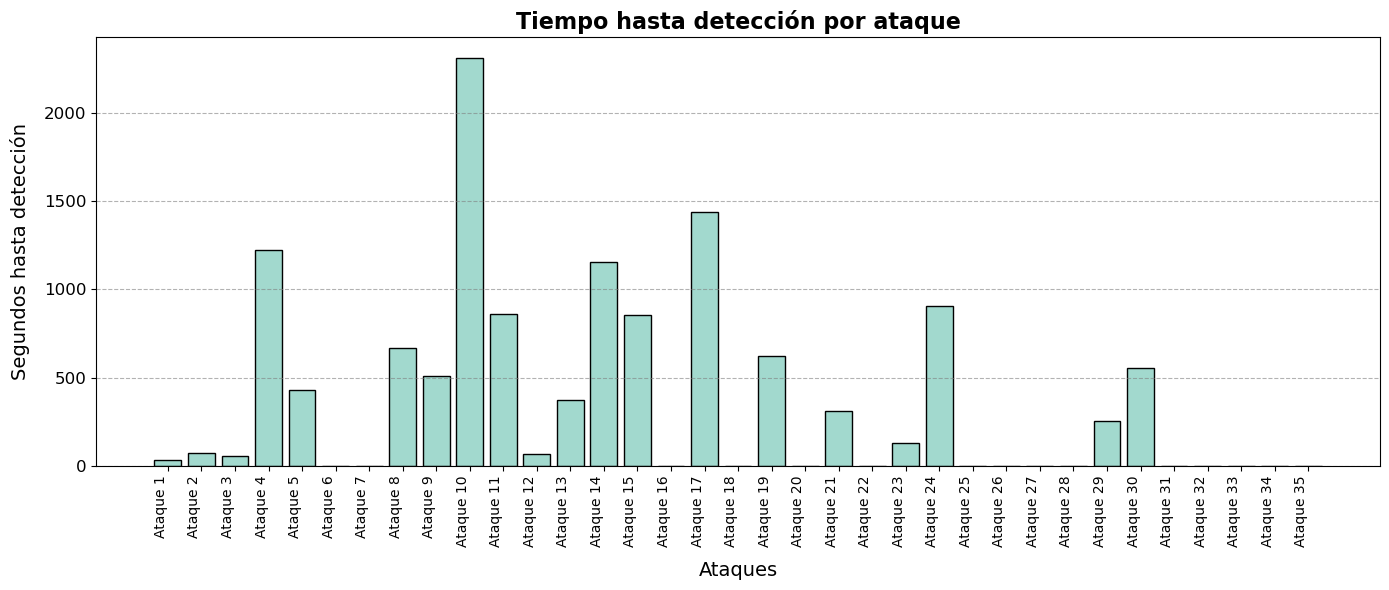

In [8]:
import matplotlib.pyplot as plt
#etiquetas de los ataques
ataques = [f"Ataque {i}" for i in range(1, 36)]

#lista de latencias de detección
tiempos_deteccion = [
    30, 75, 58, 1226, 430, 0, 0, 669, 509, 2314, 859, 64, 375, 1157, 857, 0,
    1437, 0, 625, 0, 311, 0, 128, 905, 0, 0, 0, 0, 252, 556, 0, 0, 0, 0, 0
]

plt.figure(figsize=(14, 6))
plt.bar(ataques, tiempos_deteccion, color='#a2d9ce', edgecolor='black')  
plt.xticks(rotation=90, fontsize=10, ha='right')  
plt.yticks(fontsize=12)

plt.xlabel("Ataques", fontsize=14, labelpad=10)
plt.ylabel("Segundos hasta detección", fontsize=14, labelpad=10)
plt.title("Tiempo hasta detección por ataque", fontsize=16, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.6, color='gray')
plt.axhline(0, color='black', linewidth=0.5)

plt.tight_layout()

plt.savefig("latencia_deteccion_ataques.pdf", format='pdf')

plt.show()

## 3. Cómo predice los sensores el regresor

Se muestra como el modelo predice los valores para algunos ataques, con el objetivo de comprender la gráfica anterior.

In [9]:
from datetime import datetime
import matplotlib.pyplot as plt

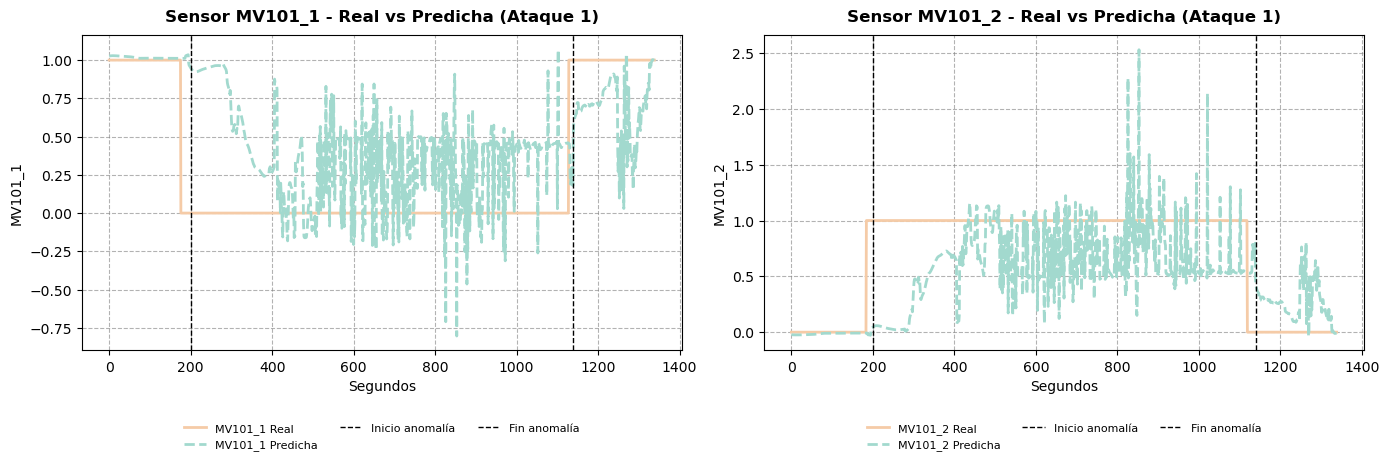

In [10]:
#ATAQUE 1

#configuración de tiempo
inicio_dataset = datetime.strptime("28/12/2015 10:00:00", "%d/%m/%Y %H:%M:%S")
inicio_ataque1 = datetime.strptime("28/12/2015 10:29:14", "%d/%m/%Y %H:%M:%S")
fin_ataque1 = datetime.strptime("28/12/2015 10:44:53", "%d/%m/%Y %H:%M:%S")

#índices globales
idx_inicio_ataque = int((inicio_ataque1 - inicio_dataset).total_seconds())
idx_fin_ataque = int((fin_ataque1 - inicio_dataset).total_seconds())    

#ventana +-200s
start = idx_inicio_ataque - 200
end = idx_fin_ataque + 200

#offset del modelo
offset_modelo = 130
df_real = test.iloc[start:end]
df_predicha = salida_modelo.iloc[start - offset_modelo : end - offset_modelo].copy()

#resetear índices para alinear con ventana
df_real = df_real.reset_index(drop=True)
df_predicha = df_predicha.reset_index(drop=True)

#índices relativos (dentro del gráfico) para marcar inicio y fin del ataque
x_inicio_anomalia = idx_inicio_ataque - start
x_fin_anomalia = idx_fin_ataque - start

#buscar primera detección de anomalía en la ventana (ajustada por offset)
anomalias = salida_modelo["Anomalía"].iloc[start - offset_modelo : end - offset_modelo].reset_index(drop=True)
indices_anomalia = anomalias[anomalias == 1].index
primer_anomalia = indices_anomalia[0] if not indices_anomalia.empty else None

#columnas a graficar
columnas = [
    'MV101_1', 'MV101_2']

#gráfico
num_filas = (len(columnas) + 1) // 2
plt.figure(figsize=(14, num_filas * 5))
colores = ['#f5cba7','#a2d9ce']

for i, columna in enumerate(columnas):
    plt.subplot(num_filas, 2, i + 1)
    plt.plot(df_real[columna], label=f'{columna} Real', color=colores[0], linewidth=2)
    plt.plot(df_predicha[columna], label=f'{columna} Predicha', color=colores[1], linestyle='--', linewidth=2)

    #líneas negras: inicio y fin del ataque (relativas a la ventana)
    plt.axvline(x=x_inicio_anomalia, color='black', linestyle='--', label='Inicio anomalía', linewidth=1)
    plt.axvline(x=x_fin_anomalia, color='black', linestyle='--', label='Fin anomalía', linewidth=1)
    plt.title(f'Sensor {columna} - Real vs Predicha (Ataque 1)', fontsize=12, fontweight='bold', pad=10)
    plt.xlabel('Segundos', fontsize=10)
    plt.ylabel(columna, fontsize=10)
    plt.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, -0.35),
        fontsize=8,
        frameon=False,
        ncol=3
    )
    plt.grid(True, linestyle='--', alpha=0.6, color='gray')

plt.tight_layout()
plt.savefig("ataque1.pdf", format='pdf')
plt.show()

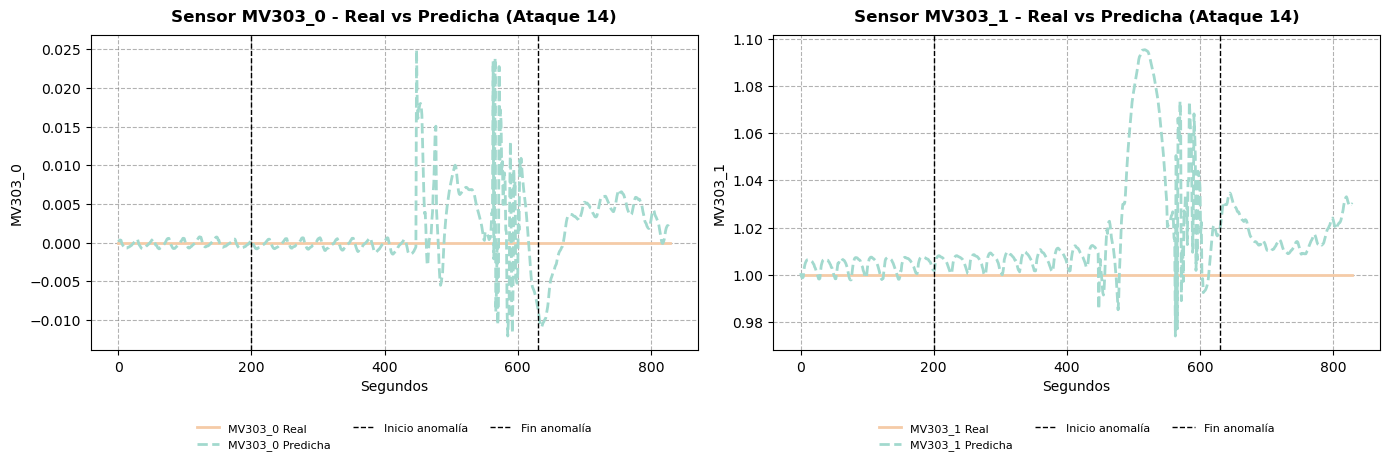

In [11]:
#ATAQUE 14

#configuración de tiempo
inicio_dataset = datetime.strptime("28/12/2015 10:00:00", "%d/%m/%Y %H:%M:%S")
inicio_ataque = datetime.strptime("29/12/2015 11:35:40", "%d/%m/%Y %H:%M:%S")
fin_ataque = datetime.strptime("29/12/2015 11:42:50", "%d/%m/%Y %H:%M:%S")

#índices globales
idx_inicio_ataque = int((inicio_ataque - inicio_dataset).total_seconds())
idx_fin_ataque = int((fin_ataque - inicio_dataset).total_seconds())

#ventana +-200s
start = idx_inicio_ataque - 200
end = idx_fin_ataque + 200

#offset del modelo
offset_modelo = 130
df_real = test.iloc[start:end]
df_predicha = salida_modelo.iloc[start - offset_modelo : end - offset_modelo].copy()

#resetear índices para alinear con ventana
df_real = df_real.reset_index(drop=True)
df_predicha = df_predicha.reset_index(drop=True)

#índices relativos (dentro del gráfico) para marcar inicio y fin del ataque
x_inicio_anomalia = idx_inicio_ataque - start
x_fin_anomalia = idx_fin_ataque - start

#buscar primera detección de anomalía en la ventana (ajustada por offset)
anomalias = salida_modelo["Anomalía"].iloc[start - offset_modelo : end - offset_modelo].reset_index(drop=True)
indices_anomalia = anomalias[anomalias == 1].index
primer_anomalia = indices_anomalia[0] if not indices_anomalia.empty else None

#columnas a graficar
columnas = ['MV303_0', 'MV303_1']

#gráfico
num_filas = (len(columnas) + 1) // 2
plt.figure(figsize=(14, num_filas * 5))
colores = ['#f5cba7', '#a2d9ce']

for i, columna in enumerate(columnas):
    plt.subplot(num_filas, 2, i + 1)

    plt.plot(df_real[columna], label=f'{columna} Real', color=colores[0], linewidth=2)
    plt.plot(df_predicha[columna], label=f'{columna} Predicha', color=colores[1], linestyle='--', linewidth=2)

    #líneas negras: inicio y fin del ataque (relativas a la ventana)
    plt.axvline(x=x_inicio_anomalia, color='black', linestyle='--', label='Inicio anomalía', linewidth=1)
    plt.axvline(x=x_fin_anomalia, color='black', linestyle='--', label='Fin anomalía', linewidth=1)
    plt.title(f'Sensor {columna} - Real vs Predicha (Ataque 14)', fontsize=12, fontweight='bold', pad=10)
    plt.xlabel('Segundos', fontsize=10)
    plt.ylabel(columna, fontsize=10)

    # --- Leyenda centrada abajo ---
    plt.legend(
        loc='lower center',
        bbox_to_anchor=(0.5, -0.35),
        fontsize=8,
        frameon=False,
        ncol=3
    )

    plt.grid(True, linestyle='--', alpha=0.6, color='gray')

plt.tight_layout()
plt.savefig("ataque14.pdf", format='pdf')
plt.show()